In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/storage/ducpm/lung-segmentation


In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

from src.models import UNet
from src.metrics import dice_coeff_vectorized
from src.data import KmaderDataset
from src.data.preprocess import *
from src.visualization import plot_batch

In [3]:
transform = transforms.Compose([
     Clip(-512, 512),
     ToTensor(),
     Normalize(low=0, high=1)
])

test_ds = KmaderDataset(
    "data/raw/kmader/3d_images/", ct_ids=["0059"], transform=transform
)

Loading CT scans: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


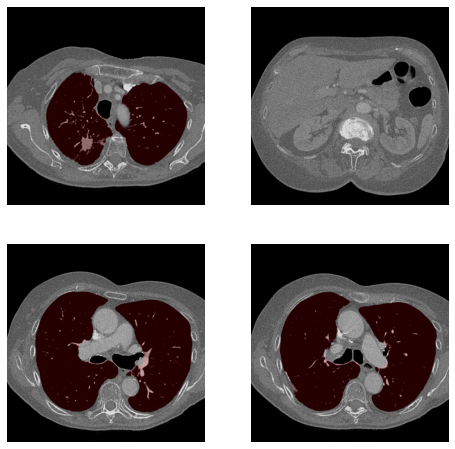

In [4]:
# quick check on dataset
loader = DataLoader(test_ds, batch_size=4, num_workers=4, shuffle=True, pin_memory=True)
sample = next(iter(loader))
plot_batch(sample["img"], sample["mask"], nrows=2, ncols=2, figsize=(8, 8))

In [5]:
device = "cuda:0"
net = UNet.load_from_checkpoint("models/unet-kmader-512-epoch=35-dice_coeff_val=0.998.ckpt").to(device)

In [9]:
test_dsc = []
for batch in tqdm(loader):
    pred_logits = net(batch["img"].to(device))
    pred_masks = torch.argmax(pred_logits, dim=1)
    # convert around-lungs mask to lungs mask 
    pred_a_lungs = pred_masks.to("cpu")
    pred_lungs = np.array([extract_mask_lungs(mask) for mask in pred_a_lungs])
    pred_lungs = torch.from_numpy(pred_lungs)
    
    dsc = dice_coeff_vectorized(pred_lungs, batch["mask"])
    test_dsc.append(dsc.item())


  0%|          | 0/76 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function tqdm.__del__ at 0x7f90263024c0>
Traceback (most recent call last):
  File "/home/ducpm/miniconda3/envs/lung-segmentation/lib/python3.8/site-packages/tqdm/std.py", line 1087, in __del__
    self.close()
  File "/home/ducpm/miniconda3/envs/lung-segmentation/lib/python3.8/site-packages/tqdm/notebook.py", line 255, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
<function tqdm.__del__ at 0x7f90263024c0>
Traceback (most recent call last):
  File "/home/ducpm/miniconda3/envs/lung-segmentation/lib/python3.8/site-packages/tqdm/std.py", line 1087, in __del__
    self.close()
  File "/home/ducpm/miniconda3/envs/lung-segmentation/lib/python3.8/site-packages/tqdm/notebook.py", line 255, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
Exception ignored in: <function tqdm.__del__ at 0x7f90263024c0>
Tra

In [13]:
import numpy as np
np.mean(test_dsc)

0.8088087525806928